In [92]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [93]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [94]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [95]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [96]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine) 

In [97]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [98]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [99]:
# Find the most recent date in the data set.
#('2017-08-23',)
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

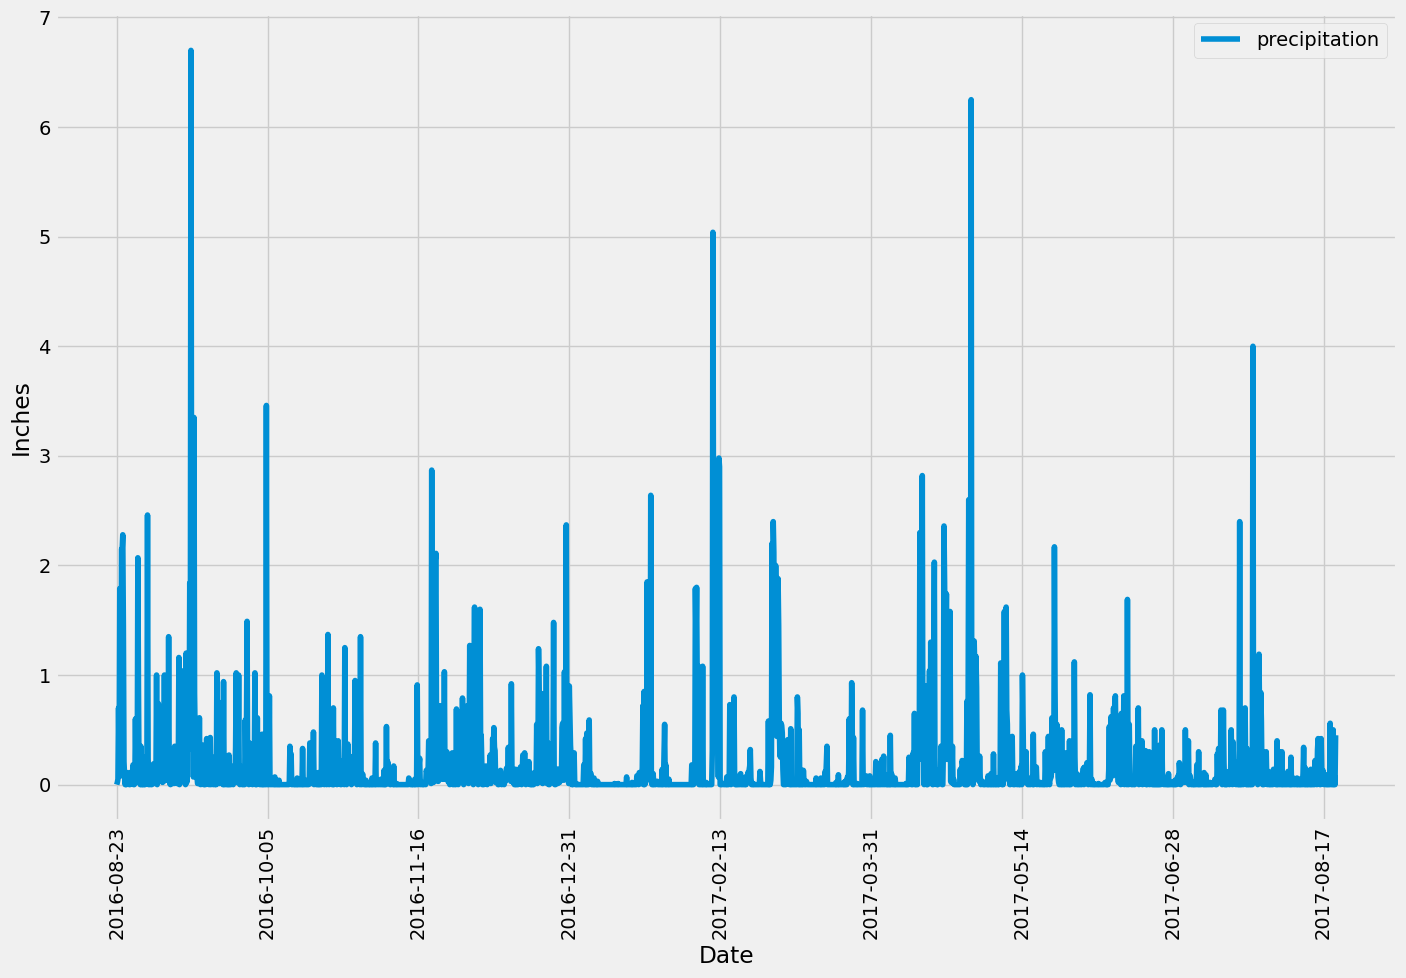

In [138]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
start = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
start = dt.datetime.strptime(start,'%Y-%m-%d')
# Calculate the date one year from the last date in data set.
last = start-dt.timedelta(days=365.25)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last).filter(Measurement.prcp!= None).all()
            
# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_dic = [{"date": val[0], "precipitation" : val[1] } for val in data]
data_df = pd.DataFrame(data_dic)

# Sort the dataframe by date
data_df = data_df.sort_values(by="date")
data_df.set_index("date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
data_df.plot(figsize=(14,10), rot=90)
plt.tight_layout()
plt.xlabel ("Date")
plt.ylabel ("Inches")
plt.show()

In [139]:
# Use Pandas to calculate the summary statistics for the precipitation data
data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [140]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all()

[(9,)]

In [134]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by (Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
station_activity        

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [135]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_activity[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

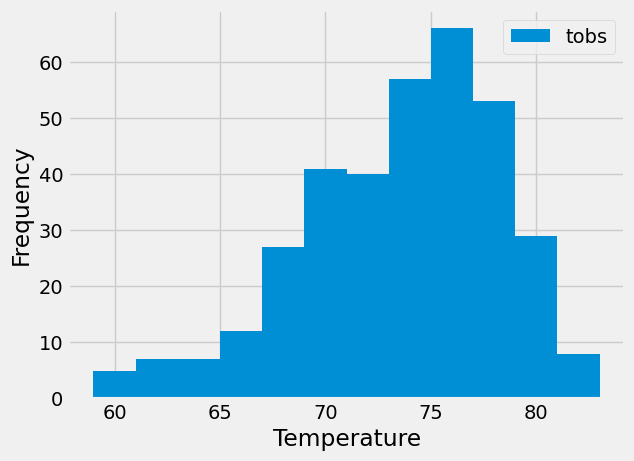

In [136]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data_temp = session.query(Measurement.tobs).\
    filter(Measurement.date >= last).filter(Measurement.station == station_activity[0][0]).all()


temp_df = pd.DataFrame(data_temp, columns=['tobs']) 
temp_df.plot.hist(bins=12) 
plt.xlabel('Temperature') 
plt.ylabel('Frequency')
plt.show() 

# Close Session

In [141]:
# Close Session
session.close()